In [ ]:
#| hide
from nbdev import *

# LAMMPS Tutorial
> This example uses ASAP3/LAMMPS potential to calculate forces and energies. This is a free calculator which can be installed either from conda-forge or separately. At the moment conda-forge version supports only linux environment.

In [ ]:
#| asap
from ase.build import bulk
from hecss import HECSS
from hecss.util import select_asap_model, create_asap_calculator
from hecss.monitor import plot_stats
from tqdm.auto import tqdm

In [ ]:
#| asap
# 2019 OpenKIM-models package (local copy)
# # There is a problem with 2021 package. ASAP cannot initialize 
# # model with this datafile. Thus we are using copy of the model
# # stored in the data directory
# model = 'data/Tersoff_LAMMPS_ErhartAlbe_2005_SiC__MO_903987585848_003'
# model = 'Tersoff_LAMMPS_ErhartAlbe_2005_SiC__MO_903987585848_003'

# # 2021 OpenKIM-models package
# model = 'Tersoff_LAMMPS_ErhartAlbe_2005_SiC__MO_903987585848_004'

model = select_asap_model('SiC')
print(f'Using potential model: {model}')

Using potential model: MEAM_LAMMPS_KangEunJun_2014_SiC__MO_477506997611_000


In [ ]:
#| asap
sys_size = '3x3x3'
sc = [int(v) for v in sys_size.split('x')]

In [ ]:
#| asap
cryst = bulk('SiC', crystalstructure='zincblende',
                 a=4.38120844, cubic=True).repeat(tuple(sc))
cryst.set_calculator(create_asap_calculator(model))

In [ ]:
#| asap
hecss = HECSS(cryst, lambda : create_asap_calculator(model))

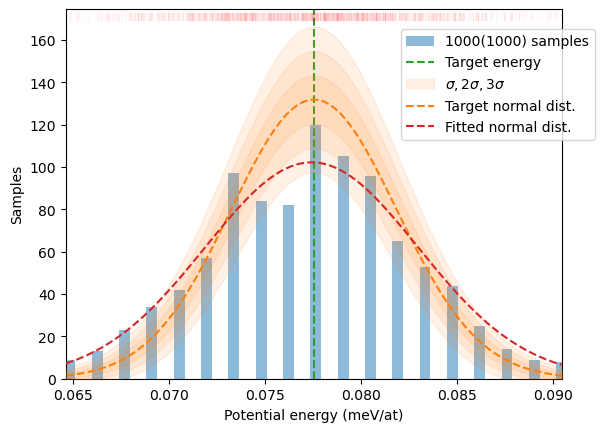

In [ ]:
#| asap
T = 600
N = 1_000
samples = hecss.sample(T,N)
plot_stats(samples, T)

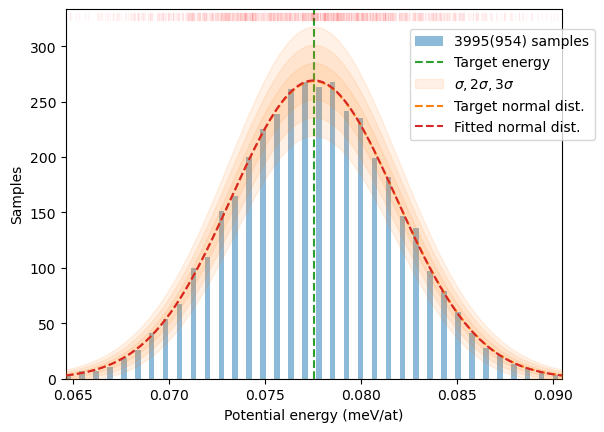

In [ ]:
#| asap
distrib = hecss.generate(samples, T)
plot_stats(distrib, T)